In [1]:
%load_ext autoreload
%autoreload 2

In [305]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

from keypoint_matching import KeypointMatcher
from RANSAC import ImageAlignment, project_2d_to_6d, project_1d_to_2d
from utils import show_two_images

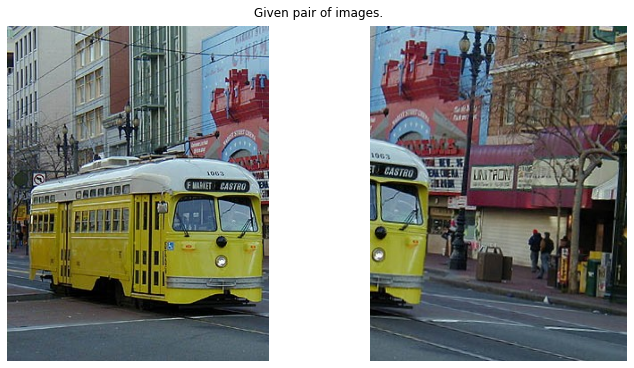

In [4]:
# read & show images
left = cv2.imread('left.jpg')
left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
left_gray = cv2.cvtColor(left, cv2.COLOR_RGB2GRAY)
right = cv2.imread('right.jpg')
right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
right_gray = cv2.cvtColor(right, cv2.COLOR_RGB2GRAY)
show_two_images(left, right, title="Given pair of images.")

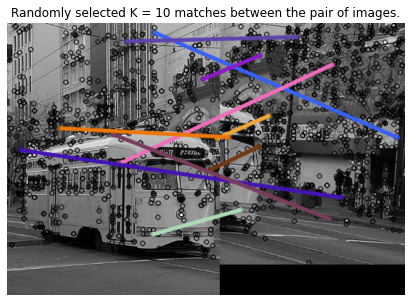

In [10]:
# get matches
kp_matcher = KeypointMatcher()
matches, kp1, des1, kp2, des2 = kp_matcher.match(left_gray, right_gray, show_matches=True)

Found 4 inliers!
Found 7 inliers!
Found 10 inliers!
Found 11 inliers!
Found 15 inliers!
Found 23 inliers!
Found 39 inliers!
Found 40 inliers!
Found 104 inliers!


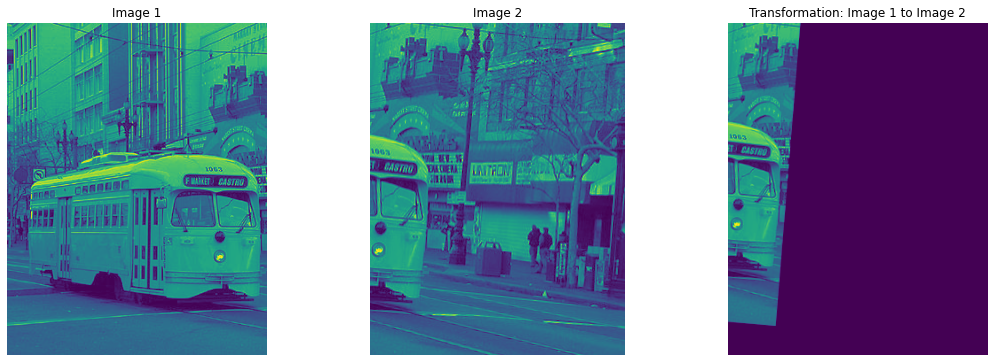

In [55]:
image_alignment = ImageAlignment()
best_params = image_alignment.align(
    left_gray, kp1, right_gray, kp2, matches, show_warped_image=True, num_matches=4, max_iter=2000
)

In [64]:
# try transforming image 2 into image 1

In [67]:
AM = np.zeros((3, 3))
AM[0, :2] = best_params[:2]
AM[1, :2] = best_params[2:4]
AM[0, 2] = best_params[4]
AM[1, 2] = best_params[5]
AM[-1, -1] = 1.0

In [68]:
AM

array([[ 9.93132136e-01, -8.07992653e-02, -2.07075667e+02],
       [ 8.61231330e-02,  9.92628444e-01, -5.53725780e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [69]:
np.linalg.inv(AM)

array([[ 9.99857521e-01,  8.13877071e-02,  2.11552810e+02],
       [-8.67503473e-02,  1.00036488e+00,  3.74288964e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [76]:
M_inv = np.linalg.inv(AM)[:2]

In [77]:
M_inv

array([[ 9.99857521e-01,  8.13877071e-02,  2.11552810e+02],
       [-8.67503473e-02,  1.00036488e+00,  3.74288964e+01]])

In [82]:
rows, cols = right_gray.shape[:2]
img2_warped = cv2.warpAffine(right_gray, M_inv, (cols, rows))

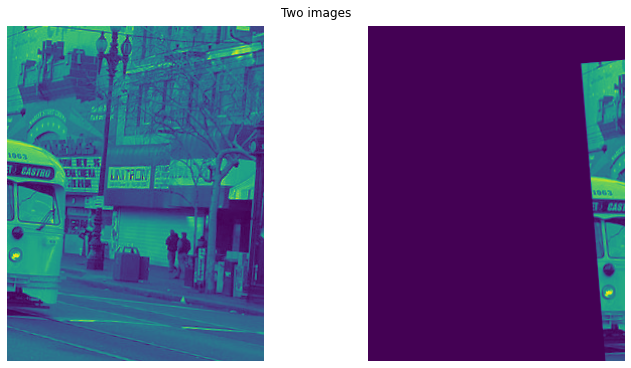

In [84]:
show_two_images(right_gray, img2_warped)

Compute corners of `right` in the co-ordinate space of `left`

In [105]:
best_params_2_to_1 = np.array([M_inv[0, 0], M_inv[0, 1], M_inv[1, 0], M_inv[1, 1], M_inv[0, 2], M_inv[1, 2]])

In [287]:
H1, W1 = left_gray.shape
C1 = np.array([[0, 0], [W1, 0], [0, H1], [W1, H1]])

In [106]:
H2, W2 = right_gray.shape

C2 = np.array([[0, 0], [W2, 0], [0, H2], [W2, H2]])
C2_viewed_from_1 = np.dot(project_2d_to_6d(C2), best_params_2_to_1)
C2_viewed_from_1 = project_1d_to_2d(C2_viewed_from_1)

In [107]:
C2

array([[  0,   0],
       [255,   0],
       [  0, 333],
       [255, 333]])

In [108]:
C2_viewed_from_1

array([[211.55280998,  37.42889644],
       [466.51647796,  15.30755787],
       [238.65491646, 370.5504019 ],
       [493.61858444, 348.42906333]])

#### Show canvas containing both images and Transformed(`right`)

In [169]:

H, W = 400, 800
canvas = np.zeros((H, W, 3))
canvas[:H1, :W1, :] = left

canvas[:H2, W - W2:, :] = right

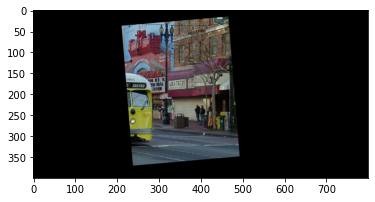

In [167]:
canvas_copy = np.zeros((H, W, 3))
canvas_copy[:H2, :W2, :] = right
canvas_copy = cv2.warpAffine(canvas_copy, M_inv, (W, H))
plt.imshow(canvas_copy.astype(int))
plt.show()

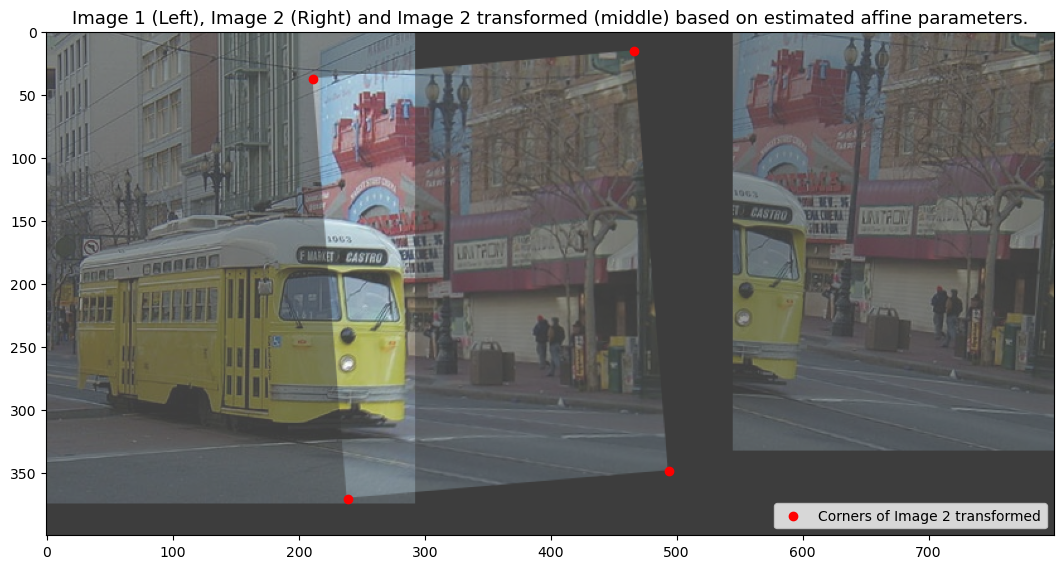

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7), dpi=100)

ax.imshow(canvas.astype(int), alpha=0.6)
ax.imshow(canvas_copy.astype(int), alpha=0.4)
ax.scatter(C2_viewed_from_1[:, 0], C2_viewed_from_1[:, 1], c="red", label="Corners of Image 2 transformed")

title = "Image 1 (Left), Image 2 (Right) and Image 2 transformed (middle) based on estimated affine parameters."
ax.set_title(title, fontsize=13)

plt.legend(loc="lower right")
plt.show()

#### Estimate the size of stiched image

In [183]:
C2_viewed_from_1

array([[211.55280998,  37.42889644],
       [466.51647796,  15.30755787],
       [238.65491646, 370.5504019 ],
       [493.61858444, 348.42906333]])

In [192]:
H_new, W_new = None, None

Y_top = np.max([0, C2_viewed_from_1[0, 1], C2_viewed_from_1[1, 1]])
Y_bot = np.min([H1, C2_viewed_from_1[2, 1], C2_viewed_from_1[3, 1]])
X_left = np.min([0, C2_viewed_from_1[0, 0], C2_viewed_from_1[3, 0]])
X_right = np.max([W1, C2_viewed_from_1[1, 0], C2_viewed_from_1[2, 0]])

H_new = Y_bot - Y_top
W_new = X_right - X_left

In [193]:
Y_top, Y_bot, X_left, X_right, \
(H_new, W_new)

(37.42889644011991,
 348.42906332634374,
 0.0,
 466.5164779645597,
 (311.00016688622384, 466.5164779645597))

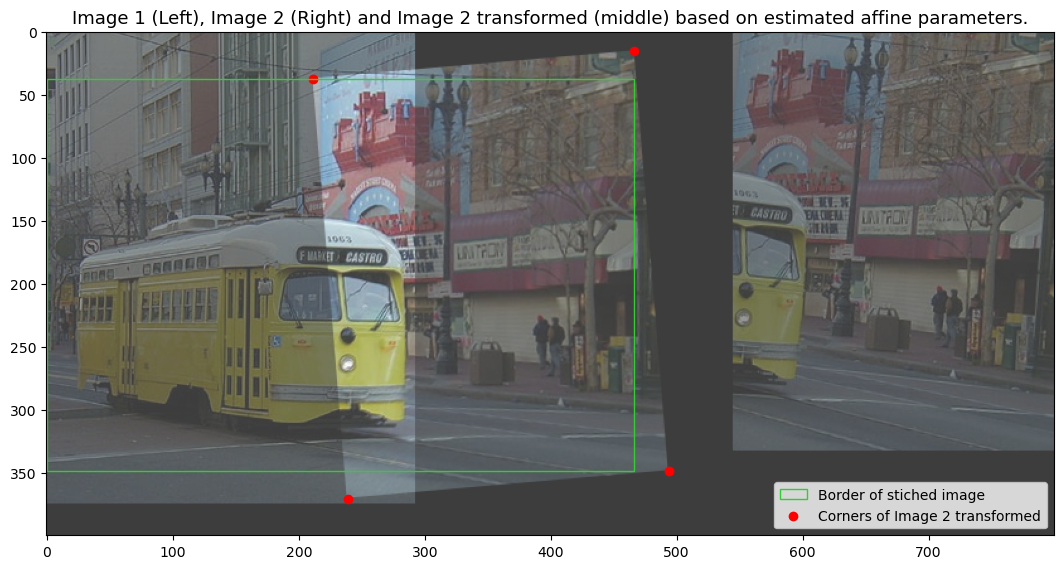

In [490]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7), dpi=100)

ax.imshow(canvas.astype(int), alpha=0.6)
ax.imshow(canvas_copy.astype(int), alpha=0.4)
ax.scatter(C2_viewed_from_1[:, 0], C2_viewed_from_1[:, 1], c="red", label="Corners of Image 2 transformed")

stiched_image_rect = Rectangle(
    (X_left, Y_top), W_new, H_new, fc='none', ec='limegreen', lw=1, label="Border of stiched image",
)
ax.add_patch(stiched_image_rect)

title = "Image 1 (Left), Image 2 (Right) and Image 2 transformed (middle) based on estimated affine parameters."
ax.set_title(title, fontsize=13)

plt.legend(loc="lower right")
plt.savefig("./results/LR_intermediate.png", bbox_inches="tight")
plt.show()

In [493]:
SEED = np.random.get_state()[1][0]

#### Fill the stiched image pixel-by-pixel

In [254]:
I = np.meshgrid(np.arange(int(X_left), int(X_right), 1), np.arange(int(Y_top), int(Y_bot), 1))[0]

In [255]:
I.shape

(311, 466)

In [256]:
int(H_new), int(W_new)

(311, 466)

In [257]:
assert I.shape == (int(H_new), int(W_new))

In [258]:
pixels = []
for x in np.arange(int(X_left), int(X_right), 1):
    for y in np.arange(int(Y_top), int(Y_bot), 1):
        pixels.append([y, x])

In [259]:
len(pixels)

144926

In [293]:
def check_point_inside_rectangle(point, rect_top_left, rect_bot_right):

    assert isinstance(point, (tuple, list, np.ndarray))
    assert len(point) == 2

    assert isinstance(rect_top_left, (tuple, list, np.ndarray))
    assert len(point) == 2

    assert isinstance(rect_bot_right, (tuple, list, np.ndarray))
    assert len(point) == 2

    x, y = point
    x1, y1 = rect_top_left
    x2, y2 = rect_bot_right
    
    return ((x <= x2) and (x > x1)) and ((y <= y2) and (y > y1))

In [294]:
check_point_inside_rectangle((0.5, 0.5), (0, 0), (1, 1)), check_point_inside_rectangle((0.5, -0.5), (0, 0), (1, 1))

(True, False)

In [384]:
C2_viewed_from_1

array([[211.55280998,  37.42889644],
       [466.51647796,  15.30755787],
       [238.65491646, 370.5504019 ],
       [493.61858444, 348.42906333]])

In [296]:
C1

array([[  0,   0],
       [293,   0],
       [  0, 375],
       [293, 375]])

In [297]:
C2_viewed_from_1

array([[211.55280998,  37.42889644],
       [466.51647796,  15.30755787],
       [238.65491646, 370.5504019 ],
       [493.61858444, 348.42906333]])

In [399]:
C2_viewed_from_1_reordered = np.array(
    [C2_viewed_from_1[0], C2_viewed_from_1[1], C2_viewed_from_1[3], C2_viewed_from_1[2]]
)

In [400]:
P2 = Polygon(C2_viewed_from_1_reordered)

In [401]:
C1_reordered = np.array([C1[0], C1[1], C1[3], C1[2]])

In [402]:
P2.contains_point((300, 300))

True

In [368]:
P1 = Polygon(C1_reordered)

In [370]:
P1.contains_point((500, 100))

False

In [377]:
C1

array([[  0,   0],
       [293,   0],
       [  0, 375],
       [293, 375]])

In [378]:
C1_reordered

array([[  0,   0],
       [293,   0],
       [293, 375],
       [  0, 375]])

In [379]:
C2_viewed_from_1_reordered

array([[211.55280998,  37.42889644],
       [466.51647796,  15.30755787],
       [493.61858444, 348.42906333],
       [238.65491646, 370.5504019 ]])

(0.0, 1000.0)

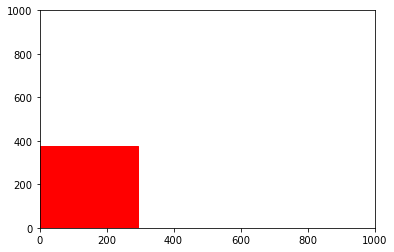

In [414]:
C1_reordered = np.array([C1[0], C1[1], C1[3], C1[2]])
P1 = Polygon(C1_reordered, color="red")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
rect = plt.Rectangle((0.2, 0.75), 0.4, 0.15, color='k', alpha=0.3)
circ = plt.Circle((0.7, 0.2), 0.15, color='b', alpha=0.3)
pgon = plt.Polygon([[0.15, 0.15], [0.35, 0.4], [0.2, 0.6]],
color='g', alpha=0.5)

ax.add_patch(rect)
ax.add_patch(circ)
ax.add_patch(pgon)
ax.add_patch(P1)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)


In [445]:
merged_image = np.zeros(canvas.shape)
merging_weights_1 = np.zeros(canvas.shape)
merging_weights_2 = np.zeros(canvas.shape)
checker = np.zeros(canvas.shape)

C1_reordered = np.array([C1[0], C1[1], C1[3], C1[2]])
P1 = Polygon(C1_reordered)

C2_viewed_from_1_reordered = np.array(
    [C2_viewed_from_1[0], C2_viewed_from_1[1], C2_viewed_from_1[3], C2_viewed_from_1[2]]
)
P2 = Polygon(C2_viewed_from_1_reordered)

for x in np.arange(int(X_left), int(X_right), 1):
    for y in np.arange(int(Y_top), int(Y_bot), 1):
        
        in_img_1 = P1.contains_point((x, y))
        in_img_2 = P2.contains_point((x, y))
        
        if in_img_1 and not in_img_2:
            merging_weights_1[y, x] = 1.0
            merging_weights_2[y, x] = 0.0

        if in_img_2 and not in_img_1:
            merging_weights_1[y, x] = 0.0
            merging_weights_2[y, x] = 1.0

        if in_img_1 and in_img_2:
            merging_weights_1[y, x] = 0.5
            merging_weights_2[y, x] = 0.5
            checker[y, x] = 1.0

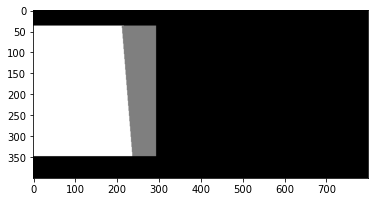

In [446]:
plt.imshow(merging_weights_1)

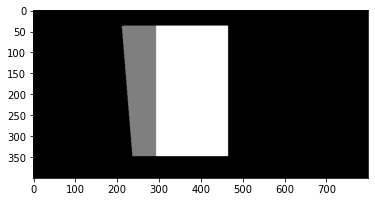

In [447]:
plt.imshow(merging_weights_2)

In [448]:
canvas.shape, canvas_copy.shape

((400, 800, 3), (400, 800, 3))

In [449]:
merging_weights_1.shape, merging_weights_2.shape

((400, 800, 3), (400, 800, 3))

In [450]:
canvas_final = np.multiply(canvas, merging_weights_1) + np.multiply(canvas_copy, merging_weights_2)

In [451]:
canvas_final_cropped = canvas_final[int(Y_top):int(Y_bot), int(X_left):int(X_right)]

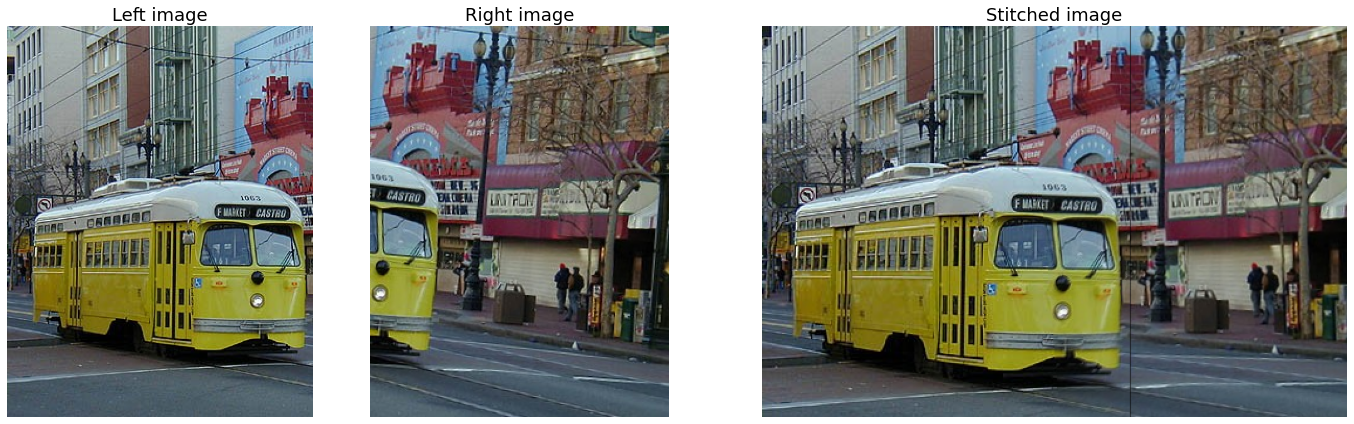

In [489]:
# generate some data
x = np.arange(0, 10, 0.2)
y = np.sin(x)

# plot it
f, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2, 2, 4]}, figsize=(20, 6))

ax[0].imshow(left)
ax[0].set_title("Left image", fontsize=18)
ax[0].axis("off")

ax[1].imshow(right)
ax[1].set_title("Right image", fontsize=18)
ax[1].axis("off")

ax[2].imshow(canvas_final_cropped.astype(int))
ax[2].set_title("Stitched image", fontsize=18)
ax[2].axis("off")

f.tight_layout()
f.savefig('./results/all_stiched.png', bbox_inches="tight")